Dataset: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

https://www.kaggle.com/code/sayamkumar/weather-image-recognition-using-cnn

In [1]:
import os
import torch, time
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import json

from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import cv2
from tqdm import tqdm

import kagglehub

# Configs

In [2]:
if torch.cuda.is_available():
    print("Device:",torch.cuda.current_device())
    print("Device Name:",torch.cuda.get_device_name())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Device: 0
Device Name: Tesla T4


In [3]:
image_size = 224
batch_size = 64
num_workers = 2
learning_rate = 1e-4
epochs = 10

# Data Loading

In [4]:
# img_transforms = transforms.Compose([
#     transforms.RandomRotation(30),
#     transforms.RandomHorizontalFlip(0.4),
#     transforms.RandomVerticalFlip(0.3),
#     transforms.Resize((240,240)),
#     transforms.CenterCrop((240,240)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
# ])

img_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

print("Path to dataset files:", path)

100%|██████████| 587M/587M [00:07<00:00, 80.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3


In [6]:
dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset", transform=img_transforms)
print(dataset.classes)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [ ]:
len(dataset)
type(dataset)

6862

In [7]:
train_set, test_set = torch.utils.data.random_split(dataset=dataset,lengths=[0.8,0.2])

In [8]:
# train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
# test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

# Visualize image samples

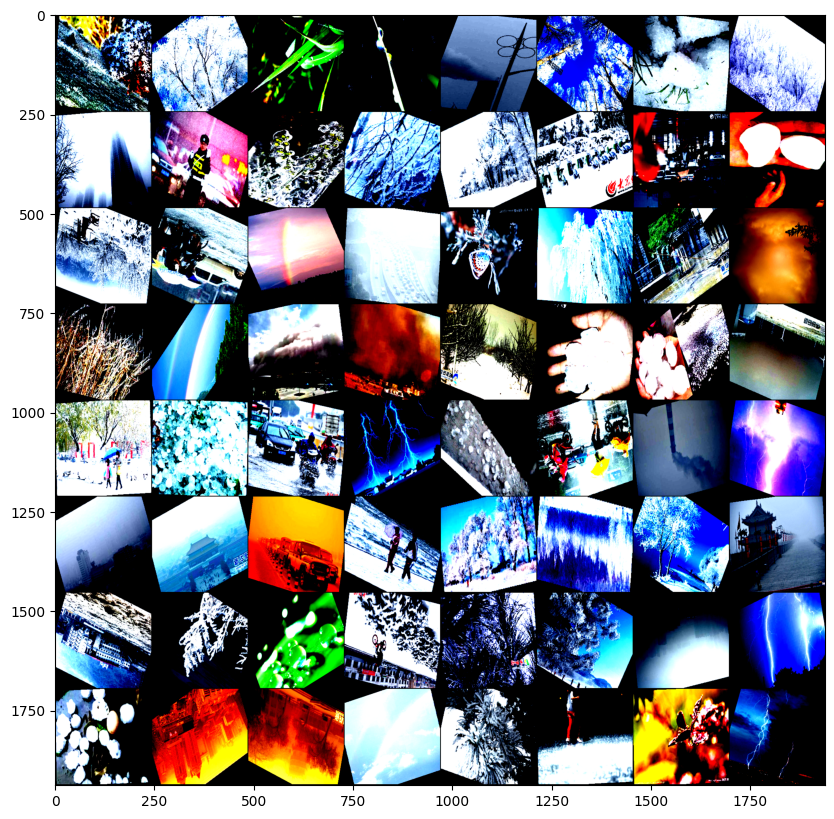

In [ ]:
for images, labels in train_loader:
    break
images.shape

img_grid = torchvision.utils.make_grid(images,nrow=8)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_images = inv_normalize(images)

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(img_grid.numpy(),(1,2,0)));

In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

label_count = count_samples_per_class(train_set)
num_classes = len(label_count)
print("Total number of data: ", len(train_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

label_count = count_samples_per_class(test_set)
num_classes = len(label_count)
print("Total number of data: ", len(test_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  5490
Number of classes: 11
Number of data samples per class: Counter({8: 936, 1: 698, 0: 547, 9: 542, 3: 500, 10: 492, 4: 469, 6: 433, 2: 379, 5: 300, 7: 194})


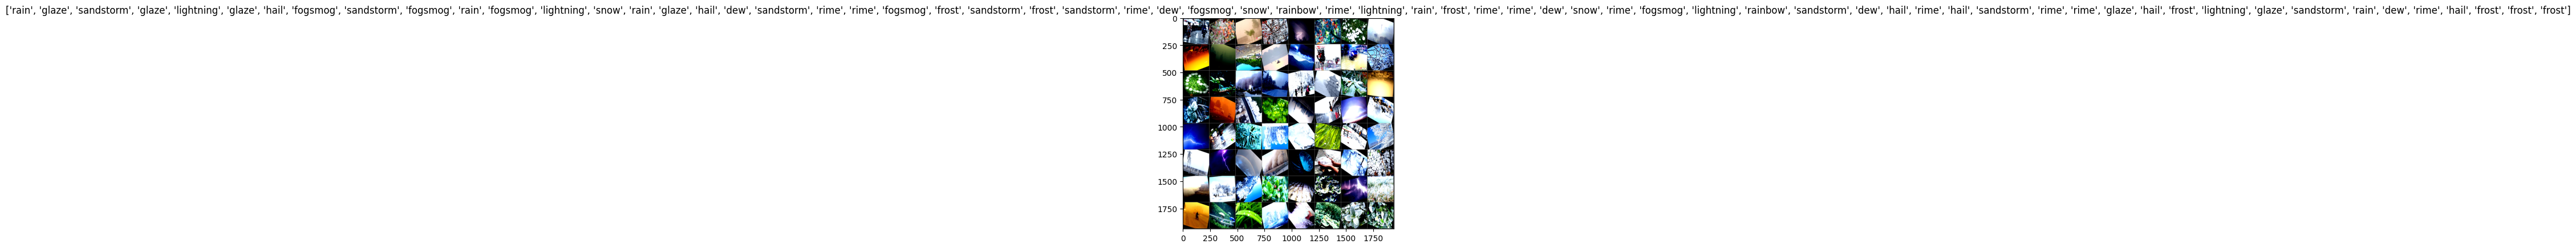

In [ ]:
def imshow(img, title):
    # Unnormalize the image
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def visualize_batch(dataloader, classes):
    # Get a batch of training data
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Make a grid from batch
    img_grid = torchvision.utils.make_grid(images)

    # Display the images
    imshow(img_grid, title=[classes[labels[j]] for j in range(len(labels))])

visualize_batch(train_loader, dataset.classes)

# CNN Model

In [34]:
resnet_model = torchvision.models.resnet50(weights='IMAGENET1K_V1').cuda()
# resnet_model = torchvision.models.resnet18(weights='IMAGENET1K_V1').cuda()
# resnet_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=0.001)

# Retraining

In [36]:
for p in resnet_model.parameters():
  p.requires_grad = False # Weights are freezed if false

In [37]:
# for p in resnet_model.named_parameters():
#   # print(p[0])
#   if 'layer4' in p[0]:
#     p[1].requires_grad = True

# for p in resnet_model.fc.parameters():
#     p.requires_grad = True

for param in resnet_model.layer4.parameters():
    param.requires_grad = True

In [38]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [39]:
# resnet_model.fc = nn.Linear(512, 102)
# resnet_model.fc = nn.Sequential(
#     nn.Linear(resnet_model.fc.in_features, 512),
#     nn.Dropout(0.5),
#     nn.ReLU(),
#     nn.Linear(512, 11)  # 11 classes
# )

resnet_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet_model.fc.in_features, 11)  # 11 classes
)

In [40]:
resnet_model = resnet_model.cuda()

In [ ]:
summary(resnet_model, (3, 224, 224))

In [41]:
start_time = time.time()
epochs = 10

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

best_val_accuracy = 0
for epoch_idx in range(epochs):

  # train_running_loss = 0.0
  # train_running_accuracy = 0.0
  # test_running_loss = 0.0
  # test_running_accuracy = 0.0

  train_correct = 0
  train_loss = 0
  train_total = 0
  test_correct = 0
  test_loss = 0
  test_total = 0

  for images, labels in train_loader:
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)

    predicted = resnet_model(images)
    loss = loss_fn(predicted, labels)

    train_loss += loss.item()
    _, preds = torch.max(predicted, 1)
    train_correct += (preds == labels).sum().item()
    train_total += labels.size(0)

    loss.backward()
    optimizer.step()

    # _, pred_arr = torch.max(predicted.detach(), 1)
    # label_arr = labels.cpu().numpy()

    # train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  # train_loss = train_running_loss / len(train_loader)
  train_losses.append(train_loss / len(train_loader))
  train_accuracy.append(train_correct / train_total)

  # Validation
  resnet_model.eval()
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)

      predicted = resnet_model(images)
      loss = loss_fn(predicted, labels)
      test_loss += loss.item()

      _, preds = torch.max(predicted, 1)
      test_correct += (preds == labels).sum().item()
      test_total += labels.size(0)
      # _, pred_arr = torch.max(predicted.detach(), 1)
      # label_arr = labels.cpu().numpy()

      # test_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  test_losses.append(test_loss / len(test_loader))
  test_accuracy.append(test_correct / test_total)

  # print(f"Training Loss at epoch {epoch_idx} is {train_loss / test_total}")
  # print(f"Training Accuracy at epoch {epoch_idx} is {train_correct / test_total}")
  # print(f"Val Loss at epoch {epoch_idx} is {test_loss / test_total}")
  # print(f"Val Accuracy at epoch {epoch_idx} is {test_correct / test_total}")
  print(f"Epoch {epoch_idx}, "
          f"Train Loss: {train_loss / train_total:.4f}, Train Acc: {train_correct / train_total:.4f}, "
          f"Val Loss: {test_loss / test_total:.4f}, Val Acc: {test_correct / test_total:.4f}")

print(f"Total time elapsed in training: {(time.time()-start_time)/60} minutes.")

Epoch 0, Train Loss: 0.0114, Train Acc: 0.8106, Val Loss: 0.0073, Val Acc: 0.8586
Epoch 1, Train Loss: 0.0081, Train Acc: 0.8412, Val Loss: 0.0074, Val Acc: 0.8622
Epoch 2, Train Loss: 0.0058, Train Acc: 0.8847, Val Loss: 0.0053, Val Acc: 0.8921
Epoch 3, Train Loss: 0.0047, Train Acc: 0.9000, Val Loss: 0.0079, Val Acc: 0.8499
Epoch 4, Train Loss: 0.0041, Train Acc: 0.9164, Val Loss: 0.0060, Val Acc: 0.8812
Epoch 5, Train Loss: 0.0041, Train Acc: 0.9151, Val Loss: 0.0048, Val Acc: 0.9067
Epoch 6, Train Loss: 0.0033, Train Acc: 0.9266, Val Loss: 0.0066, Val Acc: 0.8768
Epoch 7, Train Loss: 0.0036, Train Acc: 0.9291, Val Loss: 0.0062, Val Acc: 0.8783
Epoch 8, Train Loss: 0.0031, Train Acc: 0.9339, Val Loss: 0.0056, Val Acc: 0.8950
Epoch 9, Train Loss: 0.0032, Train Acc: 0.9319, Val Loss: 0.0050, Val Acc: 0.9031
Total time elapsed in training: 12.273681247234345 minutes.


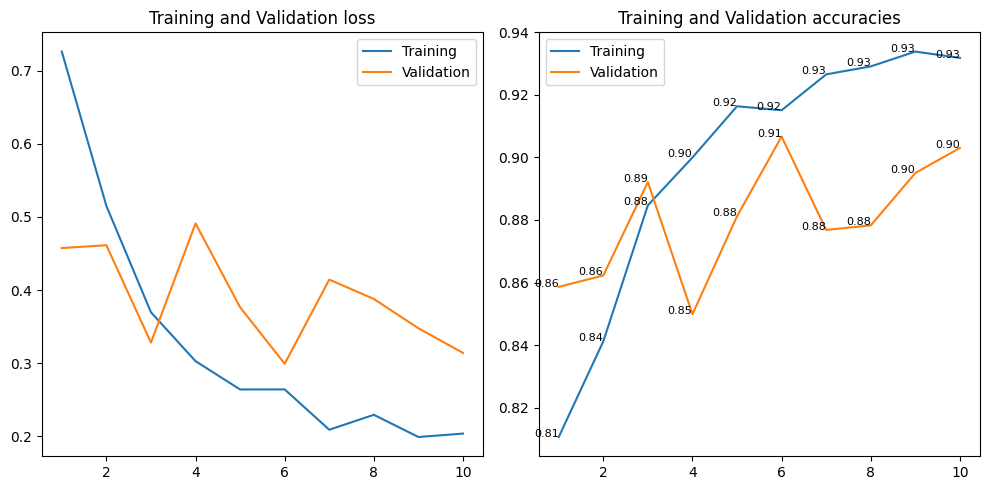

In [42]:
epochs = list(range(1, 10+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(epochs, train_losses)
axes[0].plot(epochs, test_losses)
axes[0].set_title("Training and Validation loss")
axes[0].legend(["Training", "Validation"])
axes[1].plot(epochs, train_accuracy)
axes[1].plot(epochs, test_accuracy)
axes[1].set_title("Training and Validation accuracies")
axes[1].legend(["Training", "Validation"])
# Add text annotations for training accuracy
for i, acc in enumerate(train_accuracy):
    axes[1].text(epochs[i], acc, f"{acc:.2f}", fontsize=8, ha='right')

# Add text annotations for validation accuracy
for i, acc in enumerate(test_accuracy):
    axes[1].text(epochs[i], acc, f"{acc:.2f}", fontsize=8, ha='right')

plt.tight_layout()
plt.show()

# Evaluate

In [33]:
val_running_loss = 0.0
val_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(test_loader):


  images, labels = data
  images = images.cuda()
  labels = labels.cuda()

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  if idx == 10:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 3.587948217988014
Validation Accuracy is 0.9119318181818182


# Save Model

In [ ]:
torch.save(resnet_model.state_dict(), 'resnet18_10epochs_lr1e-4.pth')

# Validation

<ipython-input-28-ec37ea11e15a>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_10epochs.pth'))


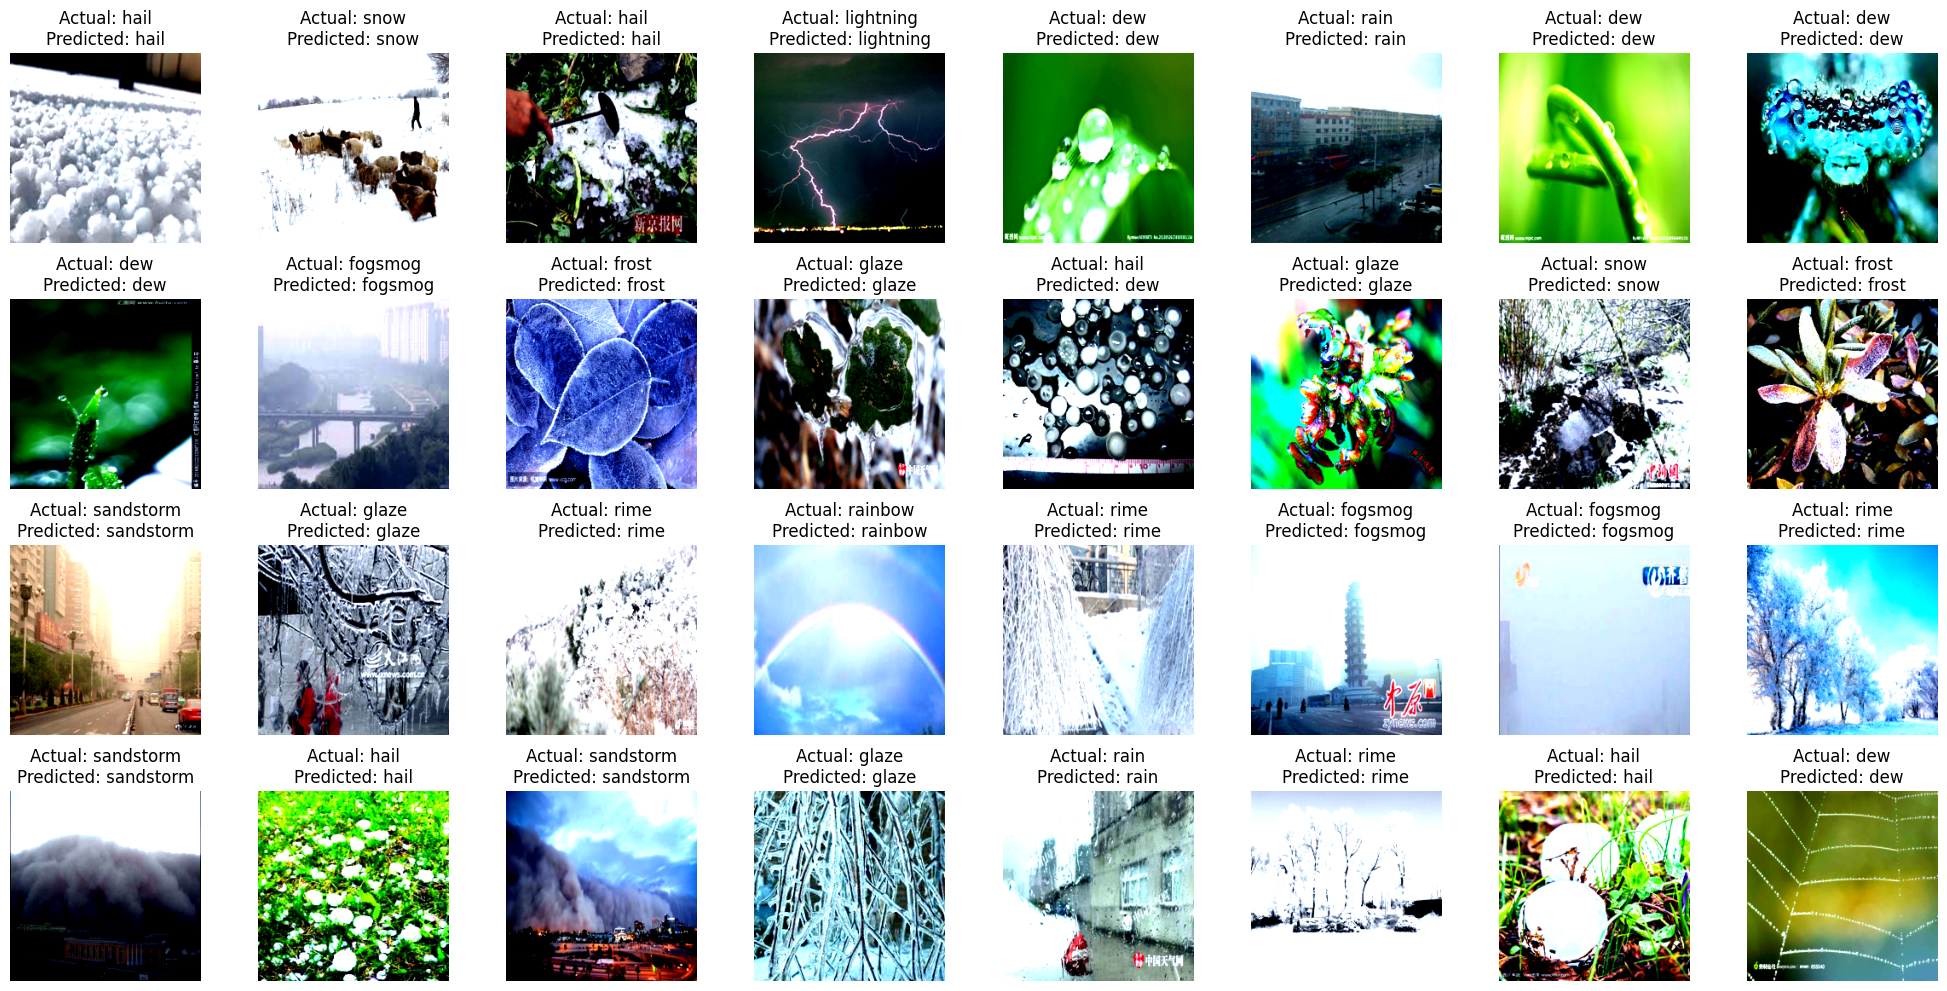

In [ ]:
# Example transformations for evaluation (including resizing to 200px)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset", transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loader for the test set
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)


# Load the trained model
model = torchvision.models.resnet50(pretrained=True)
num_classes = len(dataset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('resnet50_10epochs.pth'))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def evaluate_model(model, dataloader, classes):
    model.eval()
    images_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            images_list.extend(inputs.cpu())
            labels_list.extend(labels.cpu())
            preds_list.extend(preds.cpu())

    return images_list, labels_list, preds_list

# Get the evaluation results
images, actual_labels, predicted_labels = evaluate_model(model, test_loader, dataset.classes)

def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

def visualize_results(images, actual_labels, predicted_labels, classes, num_images=32, cols=8):
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed
    fig = plt.figure(figsize=(20, rows * 2.5))  # Adjust figure size based on rows

    for i in range(num_images):
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
        imshow(images[i], title=f"Actual: {classes[actual_labels[i]]}\nPredicted: {classes[predicted_labels[i]]}")

    plt.tight_layout()
    plt.show()

# Visualize more images (up to 32 in this example)
visualize_results(images, actual_labels, predicted_labels, dataset.classes, num_images=32)